In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import glob

In [2]:
# Function to preprocess a single DataFrame
def preprocess_df(filepath):
    df = pd.read_csv(filepath, sep=';', low_memory=False)

    df['date'] = df['date'].astype(str)  # Ensure all entries are strings
    df['date'] = df['date'].str.pad(width=20, side='right', fillchar='0') # adding a zero at the end if only one digit : useful ?
    df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True, format='%d.%m.%y %H:%M:%S:%f')
    df = df.iloc[:-1]

    # Filter trials and calculate date_diff
    df_start_trial = df[df['tagLabel'] == 'Start trial'].copy()
    df_start_trial.loc[:, 'date_diff'] = (df_start_trial.groupby('trialid')['date'].transform(lambda x: (x.max() - x.min()).total_seconds()))

    # Drop duplicates and filter by date_diff
    df_start_trial = df_start_trial.drop_duplicates(subset='trialid', keep='first')
    df_start_trial = df_start_trial[df_start_trial['date_diff'] <= 15]

    return df_start_trial

# Get a list of csv files
csv_files = glob.glob(r'F:\PM_Polyretina\Data\Post_2023_Control_Center_Data\*.csv')

# Process each csv file and store the result in a list
dfs = [preprocess_df(f) for f in csv_files]

# Concatenate all the dataframes in the list into a single dataframe
df = pd.concat(dfs, ignore_index=True)
df.head()

,participantid,trialid,fieldOfView,tagLabel,tagFov,tagTimestamp,targeteye,frameid,date,time,...,lGazeDirectionNormalisedZ,lGazeOriginX,lGazeOriginY,lGazeOriginZ,lGazePupilDiam,lGazePupilPositionSensorAreaX,lGazePupilPositionSensorAreaY,Unnamed: 70,Unnamed: 71,date_diff
0,1.0,11.0,45.0,Start trial,45.0,15.0,Right,137832.0,2023-07-05 11:34:56.670,1378.32,...,0.992447,31.58615,1.285583,-28.53294,6.374908,0.508161,0.526737,NaN,NaN,11.59
1,1.0,13.0,45.0,Start trial,45.0,15.0,Right,139867.0,2023-07-05 11:35:17.030,1398.67,...,0.949783,30.60892,0.831650,-30.03758,3.215103,0.566151,0.586483,NaN,NaN,9.56
2,1.0,15.0,45.0,Start trial,45.0,15.0,Right,141695.0,2023-07-05 11:35:35.310,1416.95,...,0.991837,32.48705,1.424545,-30.15714,3.369843,0.456453,0.552965,NaN,NaN,9.70
3,1.0,16.0,20.0,Start trial,20.0,15.0,Right,142967.0,2023-07-05 11:35:48.020,1429.67,...,0.989868,31.48267,1.418732,-27.89316,6.042206,0.512603,0.506713,NaN,NaN,14.99
4,1.0,23.0,45.0,Start trial,45.0,15.0,Right,152128.0,2023-07-05 11:37:19.630,1521.28,...,0.987045,31.45644,1.209763,-29.47694,4.131805,0.521840,0.533220,NaN,NaN,11.18


In [3]:
# Select the 'date_diff' values for each group from the filtered dataframe
df_filtered = df[df['fieldOfView'].isin([20, 45])]
group1 = df_filtered[df_filtered['fieldOfView'] == 20]['date_diff']
group2 = df_filtered[df_filtered['fieldOfView'] == 45]['date_diff']

t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False, nan_policy='omit')

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')

# Calculate the means, stds of the two groups
n1, n2 = len(group1), len(group2)
mean1, mean2 = np.mean(group1), np.mean(group2)
var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

d = (mean1 - mean2) / pooled_std
print(f"Cohen's d: {d}")


T-statistic: 2.8248724759950163
P-value: 0.004863599669070964
Cohen's d: 0.1935088643675011


9.890588235294118
9.128410256410255
10.8
9.59


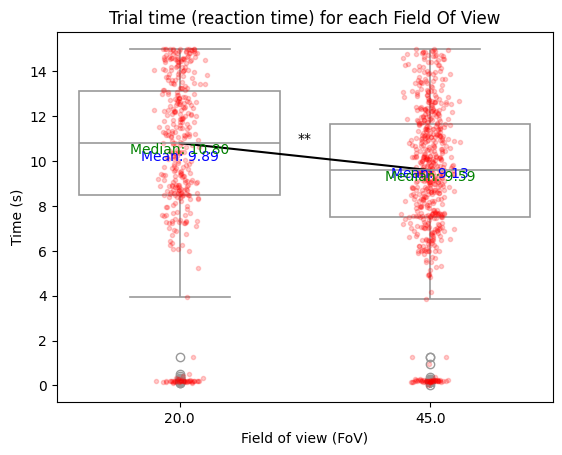

In [4]:
ax = sns.boxplot(x=df_filtered['fieldOfView'], y=df_filtered['date_diff'], color='white', linewidth=1.2)

# Add individual data points to the boxplot with reduced size and opacity
fovs = [20, 45]
for i, fov in enumerate(fovs):
    y = df_filtered.loc[df_filtered['fieldOfView'] == fov, 'date_diff']
    x = np.random.normal(i, 0.04, size=len(y))  # add jitter to the x-coordinate
    plt.plot(x, y, 'r.', alpha=0.2)

# Get the mean and median for each group
mean1 = df_filtered[df_filtered['fieldOfView'] == fovs[0]]['date_diff'].mean()
mean2 = df_filtered[df_filtered['fieldOfView'] == fovs[1]]['date_diff'].mean()
median1 = df_filtered[df_filtered['fieldOfView'] == fovs[0]]['date_diff'].median()
median2 = df_filtered[df_filtered['fieldOfView'] == fovs[1]]['date_diff'].median()

print(mean1)
print(mean2)
print(median1)
print(median2)


# Calculate the maximum y value for the annotation line
ymax = max(mean1, mean2, median1, median2)

# Draw a line between the means of two groups
plt.plot([0, 1], [median1, median2], color='black')

# Add mean and median to the plot
plt.text(0, mean1, f'Mean: {mean1:.2f}', ha='center', va='bottom', color='blue')
plt.text(1, mean2, f'Mean: {mean2:.2f}', ha='center', va='bottom', color='blue')
plt.text(0, median1, f'Median: {median1:.2f}', ha='center', va='top', color='green')
plt.text(1, median2, f'Median: {median2:.2f}', ha='center', va='top', color='green')

# Draw the text with *** indicating that the difference is significant
if p_val < 0.001:
    plt.text(0.5, ymax, '***', ha='center')
elif p_val < 0.01:
    plt.text(0.5, ymax, '**', ha='center')
elif p_val < 0.05:
    plt.text(0.5, ymax, '*', ha='center')

plt.title('Trial time (reaction time) for each Field Of View')
plt.ylabel('Time (s)')
plt.xlabel('Field of view (FoV)')
plt.show()